In [1]:
from subpred.graph import (
    preprocess_data, get_substrate_matrix, create_heatmap, get_graph_plot
)

In [2]:
organism_names= ["ecoli"]

In [3]:
organism_name_to_id = {
    "ecoli":83333,
    "yeast":559292,
    "human":9606,
    "athaliana":3702
}
organism_ids={organism_name_to_id[organism_name] for organism_name in organism_names}
dataset_name="+".join(sorted(organism_names))

datasets_folder_path="data/datasets"
go_obo_path="data/raw/ontologies/go.obo"
chebi_obo_path="data/raw/ontologies/chebi.obo"
heatmap_output_path=f"plots/heatmap_{dataset_name}.png"
graph_output_path=f"plots/graph_{dataset_name}.png"
heatmap_title = f"Substrate molecular species overlaps for substrates with 20 or more transport proteins in dataset {dataset_name}"
graph_title = f"Relations between molecular species in for substrates with 20 or more transport proteins, only including abstractions and tautomers, in dataset {dataset_name}"

Read datasets:

- Uniprot
- Uniprot GOA
- Ontologies
    - Chebi
    - GO

In [4]:
df_uniprot, df_uniprot_goa, graph_go, graph_chebi = preprocess_data(
    organism_ids=organism_ids,
    datasets_folder_path=datasets_folder_path,
    go_obo_path=go_obo_path,
    chebi_obo_path=chebi_obo_path,
)

43248
5826
2424
2424
383
164519
60547


In [5]:
import networkx as nx
chebi_id_to_name = {
            id: data["name"] for id, data in graph_chebi.nodes(data=True)
        }

# TODO only is_a

graph_chebi_isa = graph_chebi.edge_subgraph([edge for edge in list(graph_chebi.edges(keys=True)) if edge[2] == "is_a"])


In [6]:
# TODO wrong way?
[chebi_id_to_name[n] for n in list(nx.descendants(graph_chebi_isa, "CHEBI:33515"))]

['chemical entity',
 'elemental molecular entity',
 'ion',
 'monoatomic cation',
 'inorganic ion',
 'molecular entity',
 'monoatomic ion',
 'monoatomic entity',
 'metal cation',
 'inorganic cation',
 'cation',
 'inorganic molecular entity']

## Substrate matrix 

In [7]:
df_substrate_overlaps_full, dict_chebi_to_uniprot_full = get_substrate_matrix(
    datasets_folder_path=datasets_folder_path,
    graph_chebi=graph_chebi,
    graph_go=graph_go,
    df_uniprot_goa=df_uniprot_goa,
    min_overlap=20,
    max_overlap=1000000,
    include_ancestor_chebi_ids=True
)

1996
335
331


In [8]:
# df_substrate_overlaps, dict_chebi_to_uniprot = get_substrate_matrix(
#     datasets_folder_path=datasets_folder_path,
#     graph_chebi=graph_chebi,
#     graph_go=graph_go,
#     df_uniprot_goa=df_uniprot_goa,
#     min_overlap=20,
#     max_overlap="half",
#     include_ancestor_chebi_ids=False
# )
# df_substrate_overlaps

In [9]:
# df_substrate_overlaps_full_filtered = df_substrate_overlaps_full[
#     df_substrate_overlaps.columns.tolist()
# ].loc[df_substrate_overlaps.index.tolist()]

## Heatmap

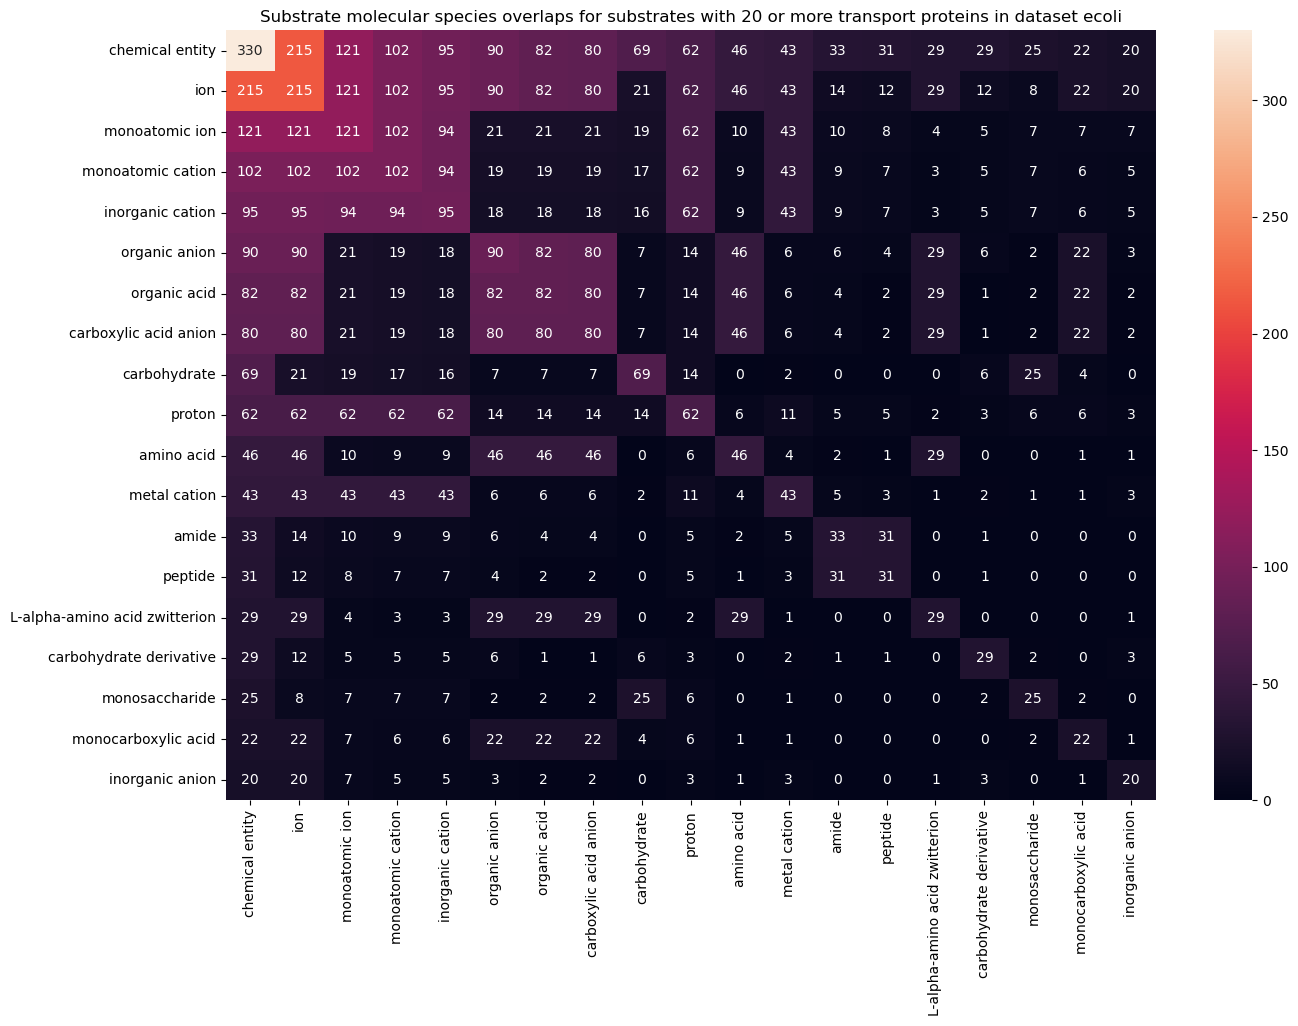

In [10]:
g = create_heatmap(
    df_matrix=df_substrate_overlaps_full,
    title=heatmap_title,
    width=15,
    height=10,
    lower_triangle_only=False,
    output_path=heatmap_output_path,
)
# from matplotlib import pyplot as plt
# g.figure.savefig("test.png",  bbox_inches='tight')

## Network

In [11]:
get_graph_plot(
    df_substrate_overlaps=df_substrate_overlaps_full,
    dict_chebi_to_uniprot=dict_chebi_to_uniprot_full,
    graph_chebi=graph_chebi,
    graph_output_path=graph_output_path,
    title=graph_title,
    node_size=8000,
    width=30,
    height=20,
    relations_paths = {"is_a", "is_tautomer_of"}
)

TypeError: get_graph_plot() got an unexpected keyword argument 'relations_paths'